# Análisis de tráfico, implementación de un IDS
#### Oscar Estrada

## Preámbulo

Instalación de librería scapy: https://scapy.readthedocs.io/en/latest/

In [1]:
pip install scapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444327 sha256=6bc56ae6f6c1da4e16eaa6765e5554109db8228185d45b6f29c53ef9bdb8e3e1
  Stored in directory: /root/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy


In [2]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns
from random import sample
import binascii
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline

Captura de 25 paquetes de mi red doméstica

In [3]:
num_of_packets_to_sniff = 25
pcap = sniff(count=num_of_packets_to_sniff)

Tipo de variable, longitud y contenido de variable de paquetes capturados.

In [4]:
print(type(pcap))
print(len(pcap))
print(pcap)

<class 'scapy.plist.PacketList'>
25
<Sniffed: TCP:25 UDP:0 ICMP:0 Other:0>


Primer paquete capturado:

In [5]:
pcap[0].show()

###[ Ethernet ]### 
  dst       = 02:42:ac:1c:00:0c
  src       = 02:42:ef:38:58:6c
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 52
     id        = 41186
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = 6
     chksum    = 0x419c
     src       = 172.28.0.1
     dst       = 172.28.0.12
     \options   \
###[ TCP ]### 
        sport     = 56798
        dport     = 8080
        seq       = 1029423531
        ack       = 3119510160
        dataofs   = 8
        reserved  = 0
        flags     = A
        window    = 501
        chksum    = 0x586c
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None), ('Timestamp', (3720728321, 1151473378))]



Contenido de 5 paquetes capturados:

In [6]:
for _ in range(5):
  indice = random.randint(0, len(pcap) - 1)
  print(pcap[indice].show())

###[ Ethernet ]### 
  dst       = 02:42:ac:1c:00:0c
  src       = 02:42:ef:38:58:6c
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 795
     id        = 41189
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = 6
     chksum    = 0x3eb2
     src       = 172.28.0.1
     dst       = 172.28.0.12
     \options   \
###[ TCP ]### 
        sport     = 56798
        dport     = 8080
        seq       = 1029424170
        ack       = 3119512086
        dataofs   = 8
        reserved  = 0
        flags     = PA
        window    = 501
        chksum    = 0x5b53
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None), ('Timestamp', (3720728611, 1151473507))]
###[ Raw ]### 
           load      = 'POST /socket.io/?EIO=3&sid=F2SBUWfa399KMawcAAAA&t=OxwRb2I&transport=polling HTTP/1.1\r\nHost: colab.research.google.com\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, 

## Análisis estadístico

Procesamiento de "analisis_paquetes.pcap" y asignación a variable

In [7]:
# Cargar el archivo PCAP en una variable
pcap = rdpcap('analisis_paquetes.pcap')
pcap

<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>

Conversion de PCAP a DF

In [8]:
# Obtenemos los campos de IP/TCP/UDP que serán las columnas de nuestro DataFrame
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

# Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']

# Creamos un DataFrame en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # Añadimos todos los valores de los campos de IP al DataFrame
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el número de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])

    field_values.append(packet.time)

    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)

    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al DataFrame
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Eliminar la antigua columna de índice
df = df.drop(columns="index")
df

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,32,84,58919,,0,122,17,13836,...,None,None,None,None,65061,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,32,84,59493,,0,122,17,13262,...,None,None,None,None,65063,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,4,5,32,84,8744,,0,122,17,64011,...,None,None,None,None,65088,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
58,4,5,0,969,1,,0,64,17,21214,...,None,None,None,None,671,None,None,941,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
59,4,5,32,84,9344,,0,122,17,63411,...,None,None,None,None,65089,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
60,4,5,0,588,1,,0,64,17,21595,...,None,None,None,None,54406,None,None,560,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


Contenido de las primeras 5 filas del dataset

In [9]:
df.head(5)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,32,84,58919,,0,122,17,13836,...,None,None,None,None,65061,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,32,84,59493,,0,122,17,13262,...,None,None,None,None,65063,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


Valores de columnas: Src Addres, Dst Address, Src Port y Dst Port

In [10]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53
...,...,...,...,...
57,84.54.22.33,10.1.10.53,53,53
58,10.1.10.53,84.54.22.33,53,53
59,84.54.22.33,10.1.10.53,53,53
60,10.1.10.53,84.54.22.33,53,53


Estadísticas

In [11]:
#a. IP Origen
ips_origen = df['src'].unique()
print("Direcciones IP de origen:")
for ip in ips_origen:
    print(ip)

#b. IP Destino
ips_destino = df['dst'].unique()
print("\n" + "Direcciones IP de destino:")
for ip in ips_destino:
    print(ip)

#c. IP de origen más frecuente
ip_origen_mas_frecuente = df['src'].mode()[0]
print("\n" + "IP de origen más frecuente:", ip_origen_mas_frecuente, "\n")

#cI. IP de destino más frecuente
ip_destino_mas_frecuente = df['dst'].mode()[0]
print("IP de destino más frecuente:", ip_destino_mas_frecuente, "\n")

#cII. Puerto de destino más común
puerto_destino_mas_comun = df['dport'].mode()[0]
print("Puerto de destino más común:", puerto_destino_mas_comun)
print("El puerto 53 se usa para el tráfico DNS. Tomando en cuenta que esto facilita la traducción de nombres de dominio a direcciones IP, es normal que sea este puerto si se está accediendo a la web. Esto ya que se está permitiendo que los dispositivos accedan a sitios web y otros servicios en línea mediante nombres de dominio.", "\n")

#cIII. Puerto de origen desde los que se comunica:
puertos_origen = df['sport'].unique()
print("Puertos de origen utilizados:")
for puerto in puertos_origen:
    print(puerto)

Direcciones IP de origen:
10.1.10.53
84.54.22.33
75.75.75.75

Direcciones IP de destino:
84.54.22.33
10.1.10.53
75.75.75.75

IP de origen más frecuente: 10.1.10.53 

IP de destino más frecuente: 10.1.10.53 

Puerto de destino más común: 53
El puerto 53 se usa para el tráfico DNS. Tomando en cuenta que esto facilita la traducción de nombres de dominio a direcciones IP, es normal que sea este puerto si se está accediendo a la web. Esto ya que se está permitiendo que los dispositivos accedan a sitios web y otros servicios en línea mediante nombres de dominio. 

Puertos de origen utilizados:
53
15812
23903


Gráficas

<ipython-input-12-93187dfe0eb6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payload', y='src', data=suma_payloads_por_ip, palette='viridis')


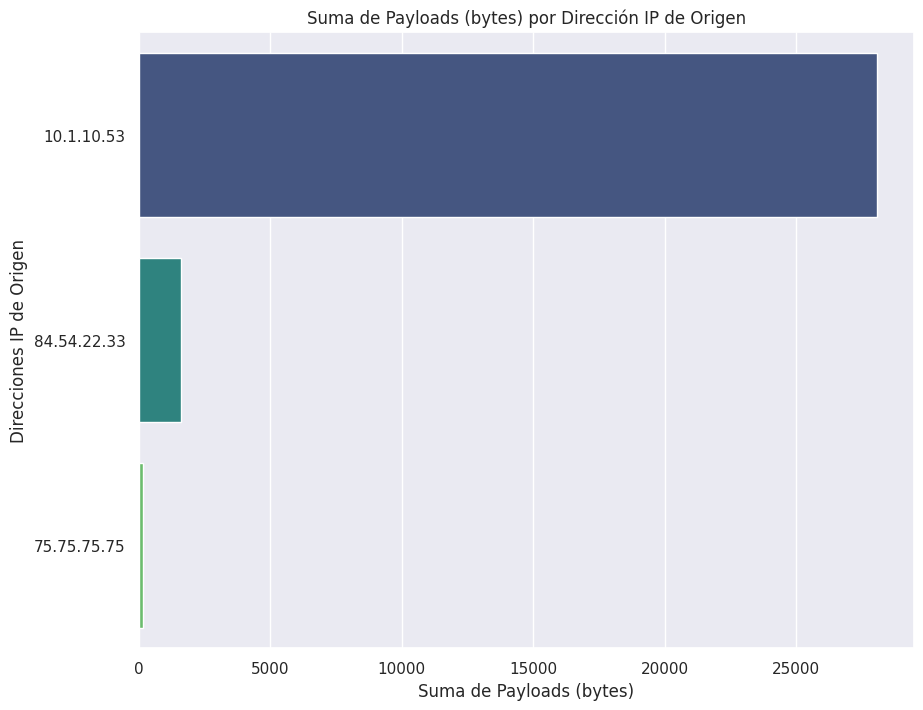

In [12]:
#a. Genere una gráfica de barras 2D horizontales, en el eje Y las IPs origen, y en el eje X la suma de los payloads (bytes) enviados desde dichas direcciones.
suma_payloads_por_ip = df.groupby('src')['payload'].sum().reset_index()
suma_payloads_por_ip = suma_payloads_por_ip.sort_values(by='payload', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='payload', y='src', data=suma_payloads_por_ip, palette='viridis')
plt.xlabel('Suma de Payloads (bytes)')
plt.ylabel('Direcciones IP de Origen')
plt.title('Suma de Payloads (bytes) por Dirección IP de Origen')
plt.show()

<ipython-input-13-3c1727b611d9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payload', y='dst', data=suma_payloads_por_ip_destino, palette='viridis')


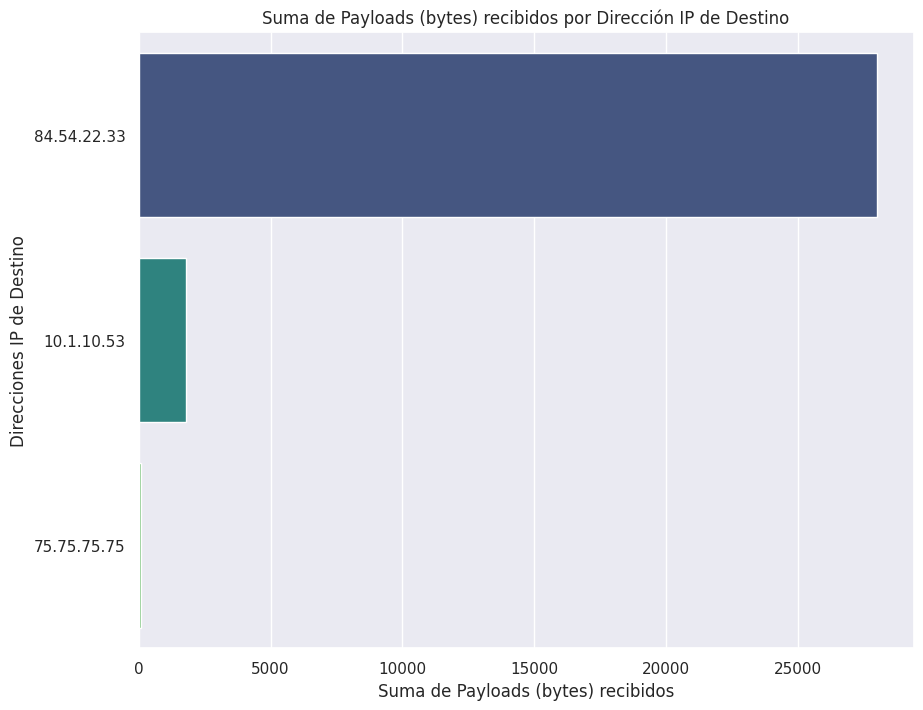

In [13]:
#b. Genere una gráfica de barras 2D horizontales, en el eje Y las IP destino, y en el eje X la suma de los payloads (bytes) recibidos en dichas direcciones.
suma_payloads_por_ip_destino = df.groupby('dst')['payload'].sum().reset_index()
suma_payloads_por_ip_destino = suma_payloads_por_ip_destino.sort_values(by='payload', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='payload', y='dst', data=suma_payloads_por_ip_destino, palette='viridis')
plt.xlabel('Suma de Payloads (bytes) recibidos')
plt.ylabel('Direcciones IP de Destino')
plt.title('Suma de Payloads (bytes) recibidos por Dirección IP de Destino')
plt.show()

<ipython-input-14-979d5720dc29>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payload', y='sport', data=suma_payloads_por_puerto_origen, palette='viridis')


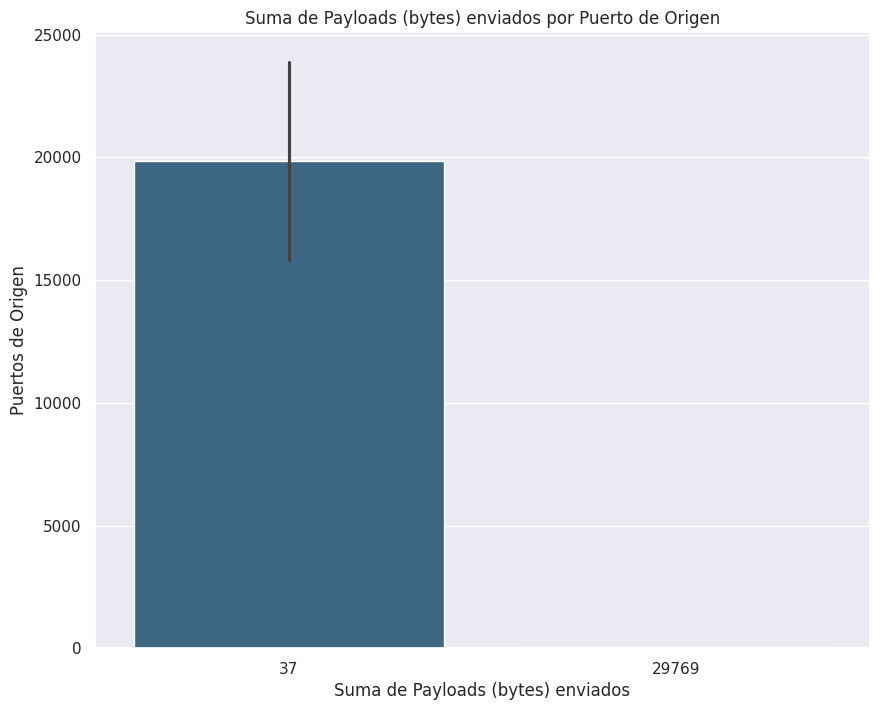

In [14]:
#c. Genere una gráfica de barras 2D horizontales, en el eje Y los puertos origen, y en el eje X la suma de los payloads (bytes) enviados de dichos puertos
suma_payloads_por_puerto_origen = df.groupby('sport')['payload'].sum().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x='payload', y='sport', data=suma_payloads_por_puerto_origen, palette='viridis')
plt.xlabel('Suma de Payloads (bytes) enviados')
plt.ylabel('Puertos de Origen')
plt.title('Suma de Payloads (bytes) enviados por Puerto de Origen')
plt.show()


<ipython-input-15-6d54edc4a295>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payload', y='dport', data=suma_payloads_por_puerto_destino, palette='viridis')


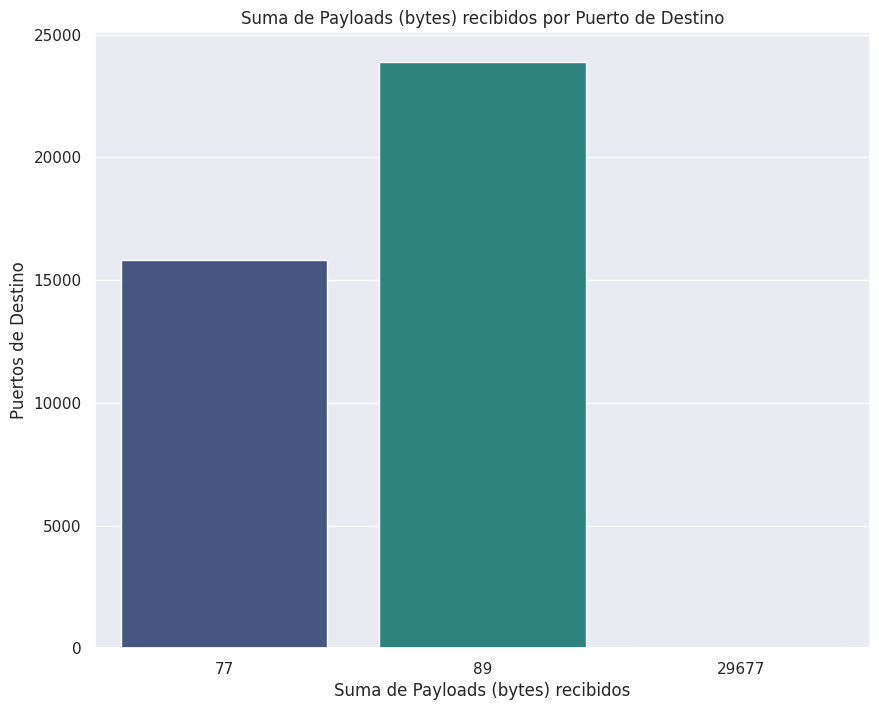

In [15]:
#d. Genere una gráfica 2D de barras horizontales, en el eje Y los puertos destino, y en el eje X la suma de los payloads (bytes) recibidos en dichos puertos.
suma_payloads_por_puerto_destino = df.groupby('dport')['payload'].sum().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x='payload', y='dport', data=suma_payloads_por_puerto_destino, palette='viridis')
plt.xlabel('Suma de Payloads (bytes) recibidos')
plt.ylabel('Puertos de Destino')
plt.title('Suma de Payloads (bytes) recibidos por Puerto de Destino')
plt.show()

<ipython-input-17-d0a3317fa672>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_rounded'] = filtered_df['time'].dt.round('1s')
<ipython-input-17-d0a3317fa672>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_rounded', y='payload', data=suma_payloads_por_tiempo, palette='viridis')


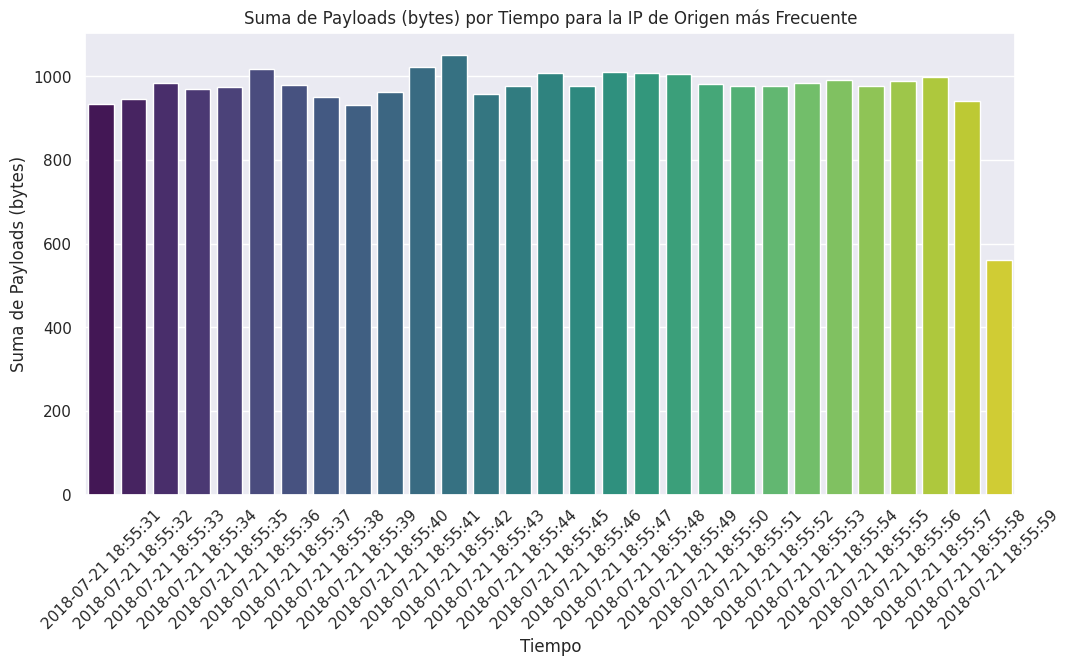

In [17]:
#e. Genere una gráfica de barras 2D verticales, en el eje Y la suma de los payload, en el eje X el tiempo, para la IP origen más frecuente
df['time'] = df['time'].astype(float)
df['time'] = pd.to_datetime(df['time'], unit='s')

most_frequent_ip = df['src'].mode()[0]
filtered_df = df[df['src'] == most_frequent_ip]

filtered_df['time_rounded'] = filtered_df['time'].dt.round('1s')
suma_payloads_por_tiempo = filtered_df.groupby('time_rounded')['payload'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='time_rounded', y='payload', data=suma_payloads_por_tiempo, palette='viridis')
plt.xlabel('Tiempo')
plt.ylabel('Suma de Payloads (bytes)')
plt.title('Suma de Payloads (bytes) por Tiempo para la IP de Origen más Frecuente')
plt.xticks(rotation=45)
plt.show()

**f. Utilizando la información de las estadísticas y la información del comportamiento del tráfico que las gráficas muestran, describa que es lo que está sucediendo. ¿Es común el comportamiento?**

En el caso del análisis tras tiempo, este tipo de comportamiento en la transmisión de datos es bastante común en redes de comunicación, donde pueden ocurrir ráfagas de actividad seguidas de períodos de menor actividad. Por otro lado, analizando las demás estadísticas, no parece haber nada inherentemente anormal en las estadísticas del tráfico de red capturado.

Investigación del Payload

In [18]:
#a. Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen más frecuente.
ip_origen_mas_frecuente = '10.1.10.53'
df_ip_origen_mas_frecuente = df[df['src'] == ip_origen_mas_frecuente].copy()
df_ip_origen_mas_frecuente.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [19]:
#b. Cree un nuevo DF que utilice el DF anterior con las columnas src, dst y payload y agrúpelas por dst y la suma del payload,
df_nuevo = df_ip_origen_mas_frecuente[['src', 'dst', 'payload']].copy()
df_agrupado = df_nuevo.groupby('dst')['payload'].sum().reset_index()
df_agrupado.head()

,dst,payload
0,75.75.75.75,74
1,84.54.22.33,27979


In [20]:
#c. Obtenga la IP destino que más ha intercambiado bytes con la IP más frecuente. Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.
df_ip_origen_mas_frecuente['payload'] = pd.to_numeric(df_ip_origen_mas_frecuente['payload'])
bytes_intercambiados_por_ip_destino = df_ip_origen_mas_frecuente.groupby('dst')['payload'].sum().reset_index()
ip_destino_sospechosa = bytes_intercambiados_por_ip_destino.loc[bytes_intercambiados_por_ip_destino['payload'].idxmax()]
print("La IP destino sospechosa es:", ip_destino_sospechosa['dst'], "con", ip_destino_sospechosa['payload'], "bytes intercambiados.")

La IP destino sospechosa es: 84.54.22.33 con 27979 bytes intercambiados.


In [27]:
#d. Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.
ip_origen_mas_frecuente = '10.1.10.53'
ip_destino_sospechosa = '84.54.22.33'
df_conversacion = df[(df['src'] == ip_origen_mas_frecuente) & (df['dst'] == ip_destino_sospechosa)]
print(df_conversacion.head())

  version ihl tos   len id flags frag ttl proto chksum  ... dataofs reserved  \
0       4   5   0   961  1          0  64    17  21222  ...    None     None   
2       4   5   0   975  1          0  64    17  21208  ...    None     None   
4       4   5   0  1012  1          0  64    17  21171  ...    None     None   
6       4   5   0   998  1          0  64    17  21185  ...    None     None   
8       4   5   0  1003  1          0  64    17  21180  ...    None     None   

  flags window chksum urgptr options payload  \
0  None   None  62990   None    None     933   
2  None   None  36378   None    None     947   
4  None   None  63846   None    None     984   
6  None   None  65315   None    None     970   
8  None   None  38088   None    None     975   

                                         payload_raw  \
0  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...   
2  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...   
4  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...   
6  b'\

In [28]:
#e. Obtenga los payloads del DF del inciso anterior, y añada cada uno en un array
payloads_array = df_conversacion['payload'].to_numpy()

#f. Muestre el contenido del array.
print("Payloads en un array:", payloads_array)

Payloads en un array: [933 947 984 970 975 1017 980 951 931 964 1023 978 958 976 1009 976 1011
 1009 1007 982 978 978 985 991 977 989 999 941 560]


Quizá en las primeras no se note nada, pero me llamó la atención el de 560,
Podría ser con una congestión momentánea en la red, donde la transmisión de datos se ve afectada y resulta en la división de los paquetes o en la transmisión de datos más pequeños (mejor de los casos). En un caso malo, por ejemplo, podría indicar intentos de evasión o técnicas de ocultación por parte de un actor malicioso, que busca transmitir datos en cantidades más pequeñas para evitar la detección. Por otro lado, también es posible que la presencia de un payload más pequeño esté relacionada con cuellos de botella en la red, lo que podría ser el resultado de una infraestructura de red subutilizada o limitaciones en los recursos de los dispositivos de red. En cualquier caso, es fundamental investigar más a fondo este comportamiento para determinar su causa y evaluar cualquier riesgo potencial para la seguridad de la red.